# Imports

In [182]:
import sys
import os 

# Add the test directory to sys.path
parent_dir = os.path.expanduser('..')
sys.path.append(parent_dir)



# Standard library imports
import importlib
import gc
import copy

# Third-party imports
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import einops
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate



# Reload modules using importlib
importlib.reload(importlib.import_module('eigenestimation.eigenhora'))
importlib.reload(importlib.import_module('eigenestimation.loss'))
importlib.reload(importlib.import_module('eigenestimation.train'))
importlib.reload(importlib.import_module('evaluation.activating_examples'))
importlib.reload(importlib.import_module('toy_models.tms'))
importlib.reload(importlib.import_module('eigenestimation.utils'))



from eigenestimation.eigenhora import EigenHora
from eigenestimation import loss
from eigenestimation.train import Train
from evaluation.activating_examples import DrawNeuralNetwork
from toy_models import tms
from eigenestimation.utils import TransformDataLoader, DeleteParams

device = 'cuda'

# TMS

In [141]:
# Load TMS model
tms_model = tms.AutoencoderSymmetric(input_dim=5, hidden_dim=2)
tms_model.load_state_dict(torch.load(f"{parent_dir}/models/tms_model.pth", weights_only=True))


<All keys matched successfully>

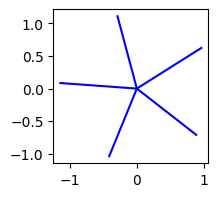

In [4]:
# Plot TMS representations.
en = copy.deepcopy(tms_model.W_in).detach().cpu().numpy().transpose()

plt.figure(figsize=(2,2))
for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'b-')
plt.show()

# Parallel TMS


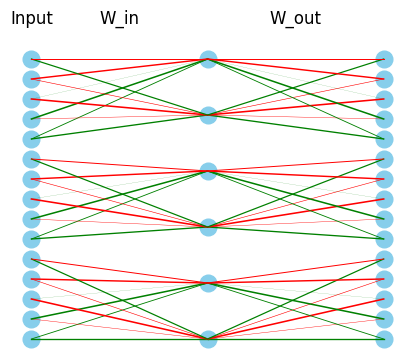

In [175]:
# Load TMS model
tms_model_p = tms.AutoencoderParallel(input_dim=5, hidden_dim=2, n_networks=3)
tms_model_p.load_state_dict(torch.load(f"{parent_dir}/models/tms_model_parallel.pth", weights_only=True))

DeleteParams(tms_model_p, [name for name, param in tms_model_p.named_parameters() if 'b' in name])

DrawNeuralNetwork(dict(tms_model_p.named_parameters()))

In [183]:
# Reload modules using importlib
importlib.reload(importlib.import_module('eigenestimation.eigenhora'))
importlib.reload(importlib.import_module('eigenestimation.loss'))
importlib.reload(importlib.import_module('eigenestimation.train'))
importlib.reload(importlib.import_module('evaluation.activating_examples'))
importlib.reload(importlib.import_module('toy_models.tms'))
importlib.reload(importlib.import_module('eigenestimation.utils'))



from eigenestimation.eigenhora import EigenHora
from eigenestimation import loss
from eigenestimation.train import Train
from evaluation.activating_examples import DrawNeuralNetwork
from toy_models import tms
from eigenestimation.utils import TransformDataLoader, DeleteParams


def model0(x):
    with torch.no_grad():
        return 0*x

n_networks = 3
n_features = 5

n_datapoints = 3*4096
X_tms_p, _, _= tms.GenerateTMSDataParallel(
    num_features=n_features, num_datapoints=n_datapoints,
    sparsity=.05,
    batch_size=16,
    n_networks=n_networks)

X_tms_p = X_tms_p.to(device)

hora_features = 15
hora_rank = 1
eigenmodel = EigenHora(tms_model_p, model0, loss.MSELoss(), hora_features, hora_rank, device=device).to(device)
dataloader = TransformDataLoader(X_tms_p, batch_size=16, transform_fn=eigenmodel.compute_jacobian)
Train(eigenmodel, dataloader, lr=.01, n_epochs=20, L0_penalty=.01, device=device)

Epoch 0 : 2.724,  Reconstruction Loss: 2.705,  Sparsity Loss: 1.854
Epoch 1 : 2.157,  Reconstruction Loss: 2.139,  Sparsity Loss: 1.803


KeyboardInterrupt: 

reconstructed network


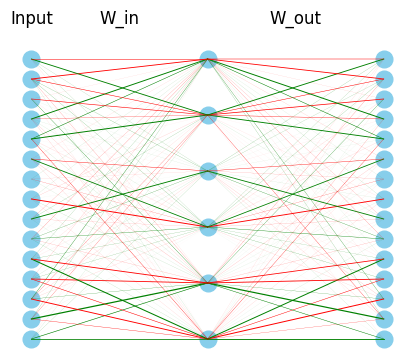

In [184]:
print('reconstructed network')
DrawNeuralNetwork(eigenmodel.reconstruct_network())


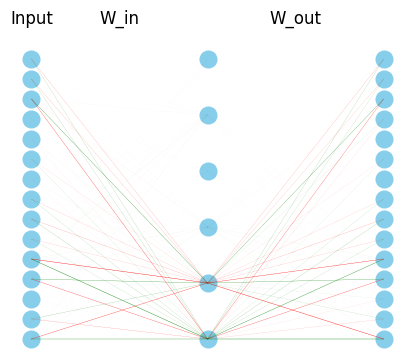

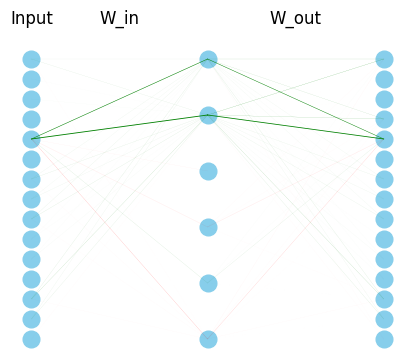

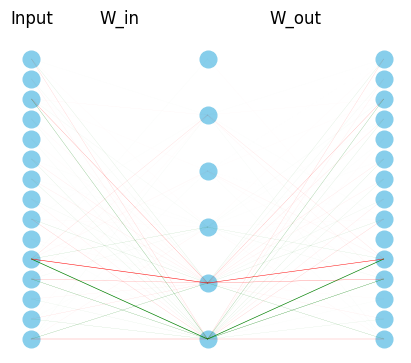

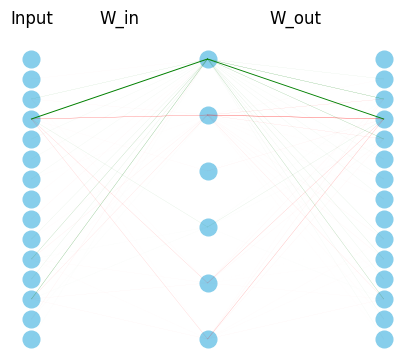

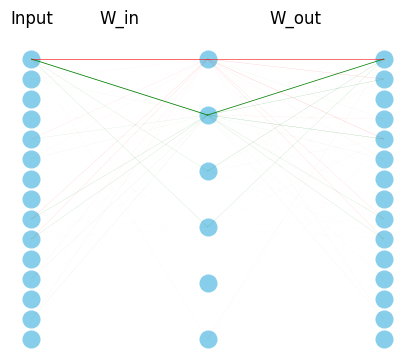

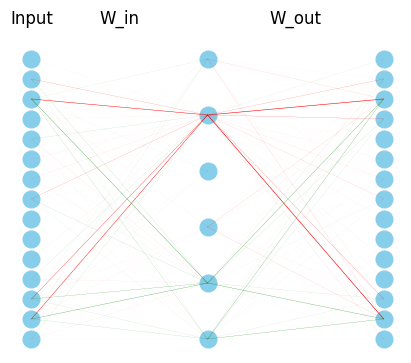

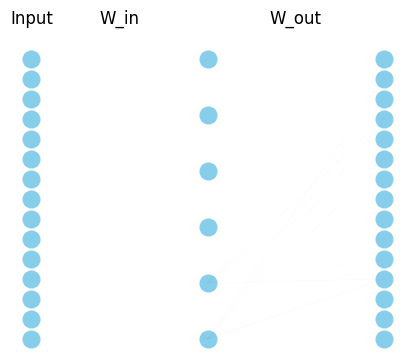

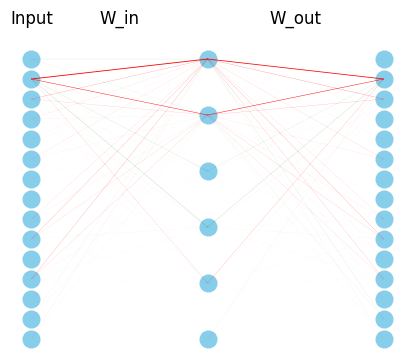

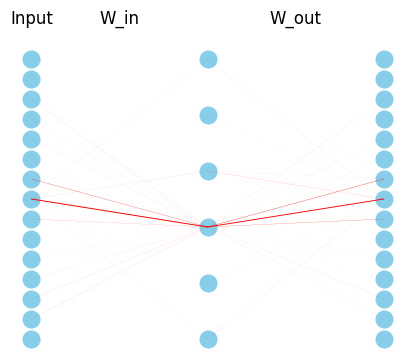

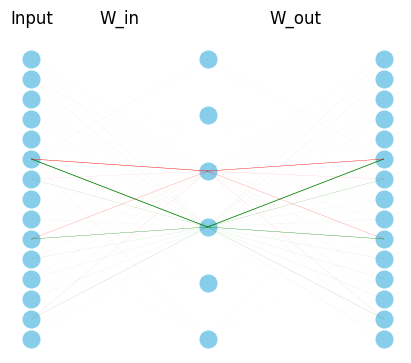

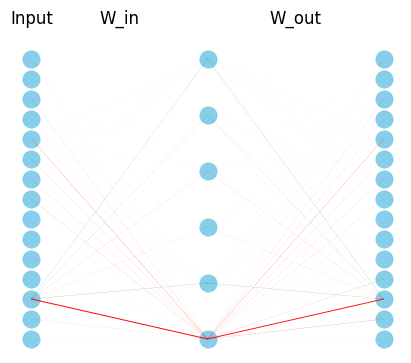

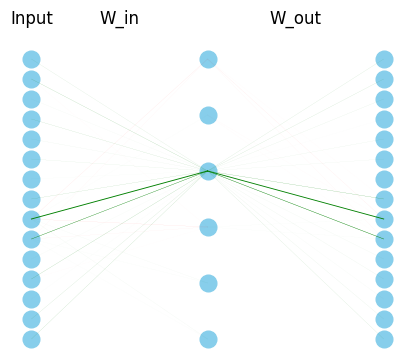

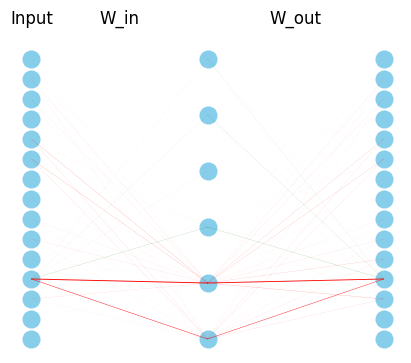

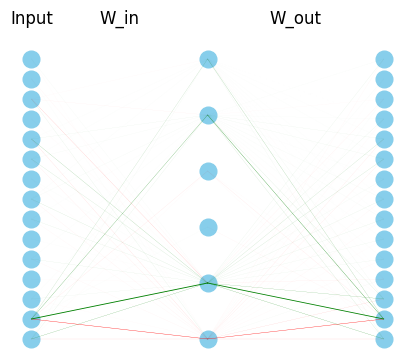

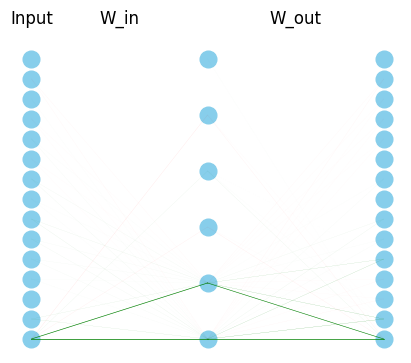

In [185]:
for network in eigenmodel.construct_subnetworks():
    DrawNeuralNetwork(network)